In [63]:
from Process import GPModeling as gpm
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from scipy.interpolate import interp1d

import importlib
importlib.reload(gpm)

<module 'Process.GPModeling' from 'C:\\Users\\Edwin\\Desktop\\OT2-DOE\\PlanPrepareProcess\\Process\\GPModeling.py'>

# Step 1: Load Data Providing Path


In [64]:
path1 = r"C:\Users\Edwin\Desktop\OT2-DOE\PlanPrepareProcess\Temp or Working\DLS\07_29_21_Dls_Viscosity_Corrected_Complete"
full_data = gpm.load_datadf(path1)

# Step 2: Apply any filters due to errors (i.e. foaming or other notable observation)


In [65]:
full_data = full_data[full_data['Run']==2]
# full_data_2 = full_data[full_data['Run']==2]

# Step 3: Visualize

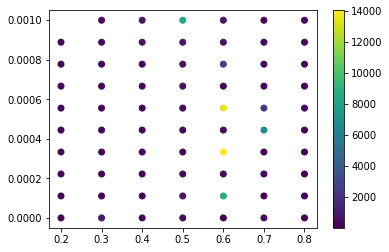

In [66]:
x_data = full_data['ethanol concentration wtf'].tolist()
y_data = full_data['Octadecane concentration wtf'].tolist()
z_data = full_data['Z-Average (d.nm)'].tolist()

plt.scatter(x_data, y_data, c = z_data)
plt.colorbar()

In [67]:
# Step 4: Place data for selection and standardize the data, in addition to formatting in the correct array shape

In [68]:
# load and standardize data
x1_training = np.asarray(x_data) # simple n x 1
x2_training = np.asarray(y_data)
y_training = np.asarray(z_data)

x1_training_scaled, x1_scaler = gpm.standardize_training(x1_training) # create n x 1 x 1 [[x11],[x12]]
x2_training_scaled, x2_scaler = gpm.standardize_training(x2_training)
y_training_scaled, y_scaler = gpm.standardize_training(y_training)
x1x2_training_scaled = gpm.coupled_two_arrays(x1_training_scaled, x2_training_scaled) # creates [[x11, x21],[x12, x22]]


In [72]:
# Create the model and fit the data 

# kernel = RBF(length_scale=[0.1, 0.0001], length_scale_bounds=[(0.001, 1000), (0.0001, 1)]) # so sometimes even with the same hyperparameters 

kernal = 1.0 * RBF(length_scale=60, length_scale_bounds=(1e-3, 1e5)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)) 

gpmodel = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10,alpha=0.05, normalize_y=True) # random_state=42
gpmodel.fit(x1x2_training_scaled, y_training_scaled)
# gpmodel.kernel.length_scale, gpmodel.kernel.length_scale_bounds
gpmodel.kernel.get_params()

{'length_scale': [0.01, 1],
 'length_scale_bounds': [(1e-06, 1000), (1e-25, 1000)]}

In [73]:
# Set the scale for how big you want the mesh to extend from
x1x2_test, x1_test, x2_test = gpm.create_mesh_from_min_max(x1_training_scaled, x2_training_scaled, scale = 1.5)

# Run the test data through and convert results back from standardized to original units
x1_test_ex = x1x2_test[:,0][:,0]
x2_test_ex = x1x2_test[:,1][:,0]
x1x2_test_reform = np.asarray([x1_test_ex, x2_test_ex]).T
y_pred, MSE = gpmodel.predict(x1x2_test_reform, return_std=True) 

x1_test_org = gpm.reverse_standardization(x1_scaler, x1x2_test[:,0])
x2_test_org = gpm.reverse_standardization(x2_scaler, x1x2_test[:,1])
y_pred_org =  gpm.reverse_standardization(y_scaler, y_pred)

# Select data of interst and create meshes
x1 = x1_training
x2 = x2_training
y = y_training

dim_x1_test = x1_test.shape[0] 
dim_x2_test = x2_test.shape[0]

x1_mesh_prep = np.asarray([round(i,12) for i in x1_test_org[:,0]])
x2_mesh_prep = np.asarray([round(i,12) for i in x2_test_org[:,0]])
y_mesh_prep = np.asarray([round(i,5) for i in y_pred_org[:,0]])

X1 = x1_mesh_prep.reshape(dim_x2_test, dim_x1_test)
X2 = x2_mesh_prep.reshape(dim_x2_test, dim_x1_test)
Y = np.reshape(y_mesh_prep,(dim_x2_test, dim_x1_test))

gpmodel.score(x1x2_training_scaled, y_training_scaled, [1]*len(y_training_scaled))
# gpmodel.log_marginal_likelihood
# # hmm play with this score and see what you can change in your kernal to modify it
# MSE

0.9977324263038548

(-0.0001, 0.0011)

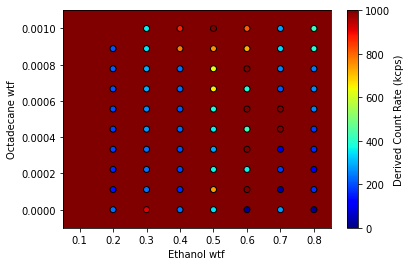

In [74]:
fig, ax = plt.subplots(1)
vmin = 0 
vmax = 1000
norm =colors.Normalize(vmin=vmin,vmax=vmax) 

mappable = ax.pcolormesh(X1,X2,Y, norm=norm, shading = 'auto',cmap='jet')
cbar = fig.colorbar(mappable)
cbar.ax.set_ylabel('Derived Count Rate (kcps)')
ax.scatter(x1,x2,c=y, norm=norm, edgecolors='k',cmap='jet')
ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('Octadecane wtf')
ax.set_xlim(0.05,0.85)
ax.set_ylim(-0.0001,0.0011)

# plt.plot(ex_new, f(ex_new), '-', label='10C')
# plt.plot(ex_new_30, f30(ex_new), '-', label='30C')
# plt.plot(ex_new_60, f60(ex_new), '-', label='60C')
# plt.legend()

In [ ]:
solubility_data = pd.read_excel(r"C:\Users\Edwin\Desktop\octadecene\octadecene solubility.xlsx")
solubility_data.columns = solubility_data.loc[0]
solubility_data = solubility_data.drop(0)
etoh = solubility_data['Ethanol wt% ']/100
ode_30 = solubility_data['30 C ']/100
ode_10 = solubility_data['10 C ']/100
ode_60 = solubility_data['60 C']/100

selected = ode_10
ex = etoh[selected.notnull()]
oy = selected[selected.notnull()]
plt.scatter(ex, oy)
f = interp1d(ex, oy, kind='linear')
ex_new = np.linspace(0, 1, num=20, endpoint=True)
plt.plot(ex, oy, 'o', ex_new, f(ex_new), '-')

selected = ode_30
ex = etoh[selected.notnull()]
oy = selected[selected.notnull()]
plt.scatter(ex, oy)
f30 = interp1d(ex, oy, kind='linear')
ex_new_30 = np.linspace(0, 1, num=20, endpoint=True)
plt.plot(ex, oy, 'o', ex_new_30, f30(ex_new), '-')

selected = ode_60
ex = etoh[selected.notnull()]
oy = selected[selected.notnull()]
plt.scatter(ex, oy)
f60 = interp1d(ex, oy, kind='linear')
ex_new_60 = np.linspace(0, 1, num=20, endpoint=True)
plt.plot(ex, oy, 'o', ex_new_60, f60(ex_new), '-')